In [16]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
import os
import scipy as sp
root = '/mnt/cube/tsainbur/Experiments/ephys_analysis/B1169/MDA'
import pickle
matplotlib.rcParams.update({'font.size': 18})


In [ ]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

In [17]:
loc_dat1 = root + '/Spikes_B1169_left_AP2500_ML500_Z1450.pickle'
fid1 = open(loc_dat1,'rb')
spks = pickle.load(fid1)
#loc_dat2 = loc_dat + 'trials.pickle'
loc_dat2 = root + '/trial-data_B1169_left_AP2500_ML500_Z1450.pickle'
fid2 = open(loc_dat2,'rb')
trials = pickle.load(fid2)

In [34]:
stim_lab = list(trials['stimulus'])
good = [i[:2]!='CL' for i in stim_lab]
grid_trials = trials[good]
grid_trials
stim_lab = list(grid_trials['stimulus'])
stim_lab

['-7d5_-12d5',
 '-5d625_-6d875',
 '-14d375_-4d375',
 '0d3125_-0d3125',
 '-9d6875_-4d0625',
 '-12d1875_-4d0625',
 '0d625_-10d625',
 '-1d875_-1d875',
 '-6d5625_-7d8125',
 '-13d4375_-9d0625',
 '-11d5625_-7d8125',
 '-1d5625_-8d4375',
 '-10d9375_2d8125',
 '-11d875_-10d625',
 '-4d6875_-7d1875',
 '-4d0625_2d1875',
 '-7d5_2d5',
 '-5d9375_-14d6875',
 '-9d375_-3d125',
 '-6d875_-0d625',
 '-4d375_-6d875',
 '2d1875_-9d0625',
 '-1d5625_-9d0625',
 '2d8125_-10d9375',
 '-5d3125_2d1875',
 '-7d5_-7d5',
 '-1d875_-3d125',
 '-9d6875_-4d6875',
 '-13d4375_0d3125',
 '-6d875_-14d375',
 '-3d4375_-8d4375',
 '-14d375_-8d125',
 '0d3125_-12d8125',
 '-4d0625_-13d4375',
 '3d4375_-0d3125',
 '-9d6875_-9d6875',
 '-10d9375_0d3125',
 '-12d1875_-10d9375',
 '-6d5625_-9d6875',
 '-6d25_-3d75',
 '-12d8125_-0d3125',
 '-6d5625_-0d9375',
 '-14d0625_-1d5625',
 '3d125_-0d625',
 '-12d1875_-3d4375',
 '0d9375_0d9375',
 '-14d0625_-4d0625',
 '-6d5625_-12d1875',
 '2d8125_-1d5625',
 '-6d875_-5d625',
 '1d5625_1d5625',
 '-4d6875_-5d3125',
 '

In [40]:
# TSa
grid_trials['stim_points'] = [[float(j.replace('d', '.')) for j in i.split('_')] for i in grid_trials['stimulus'].values]
stim_locs = np.stack(grid_trials['stim_points'].values)
stim_locs

/home/AD/tsheehan/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


array([[ -7.5     , -12.5     ],
       [ -5.625   ,  -6.875   ],
       [-14.375   ,  -4.375   ],
       ..., 
       [ -1.796875,  -8.828125],
       [ -2.578125,   1.953125],
       [ -1.953125,   3.359375]])

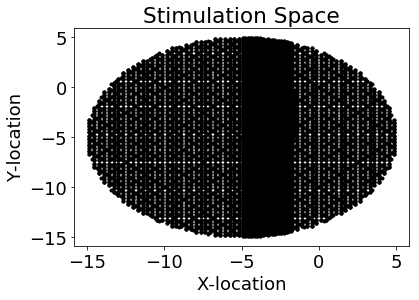

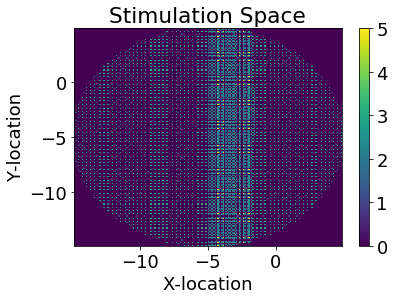

In [41]:
stim_labels = list(grid_trials.stim_points)
stim_labels = np.stack(grid_trials.stim_points)
plt.plot(stim_labels[:,0],stim_labels[:,1],'k.')
plt.xlabel('X-location')
plt.ylabel('Y-location')
plt.title('Stimulation Space')
plt.show()

plt.hist2d(stim_labels[:,0],stim_labels[:,1],bins=200)
plt.xlabel('X-location')
plt.ylabel('Y-location')
plt.title('Stimulation Space')
plt.colorbar()
plt.show()

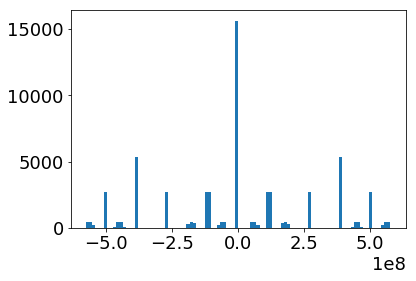

In [53]:
st_times = grid_trials['time_samples']
d_times = list(st_times[1:]-st_times[:-1])
plt.hist(d_times,100)
plt.show()


In [62]:
def cluster_sum(spks,trials,clust_use=3,x_use=14):
    if not 'lTrial' in globals():
        lTrial = len(trials)
    # trials
    stim_labels = list(trials.stim_points)
    stim_labels = np.stack(trials.stim_points)
    st_time = np.array(trials[:lTrial].time_samples)
    ed_time = np.array(trials[:lTrial].stimulus_end)
    stim_len = ed_time[0] - st_time[0]
    print(stim_len)
    #spikes
    clust = list(set(spks.cluster))
    unit_use = clust[clust_use] #3
    spk_times = np.array(spks[spks.cluster==unit_use].time_samples)
    my_spikes = np.zeros(np.max(spk_times)+1,dtype=int)
    my_spikes[spk_times] = int(1)
    st_time = np.array(trials[:lTrial].time_samples)
    # sort latent space
    x_pts = stim_labels[:lTrial,0]
    y_pts = stim_labels[:lTrial,1]
    x_val = np.unique(x_pts)
    y_val = np.unique(y_pts)
    # get PSTH
    x_use = x_pts[x_use] # 6
    pts_want = x_pts==x_use
    pre_offset = -10*1000
    PSTH = spks_in_win(my_spikes,st_time[pts_want]+pre_offset,40*1000)
    # sort by y-location
    spk_loc = np.where(PSTH>=1)
    spk_loc = [x+pre_offset for x in spk_loc]
    val_pts_want = np.where(np.array(pts_want))
    probe_y = y_pts[pts_want]

    # ISI
    ISI = get_ISI(spk_times)
    ISI = ISI[ISI<40*40]
    too_soon = np.round(np.mean(ISI<min_thresh)*100,2)
    
    # plotting
    plt.figure(figsize=(6,4))
    plt.subplot(1,2,1)
    plt.hist(ISI/40,50)
    plt.xlabel('ISI (ms)')
    plt.ylabel('Count')
    plt.title('Below min: ' + str(too_soon) + '%')
    
    plt.subplot(1,2,2)
    plt.hist(spk_loc[0],30)
    yl = np.squeeze([plt.gca().get_ylim()])
    plt.plot([0, 0],yl,'r--')
    plt.plot([stim_len, stim_len],yl,'r--')
    plt.title('Cluster:'+ str(unit_use))
    
    

In [67]:
# check time distribution of events
#trials
# GET PSTH for a given set of windows
def spks_in_win(spks,st_time,win_len):
    #st_time[st_time>len(spks)] = []
    st_time = np.delete(st_time,np.where(st_time>len(spks)))
    n_trials = len(st_time)
    PSTH = np.zeros((win_len,n_trials))
    for i in range(n_trials):
        this_win = np.arange(st_time[i],st_time[i]+win_len)
        PSTH[:,i] = spks[this_win]
    return PSTH
def get_ISI(spk_times):
    d_spk = spk_times[1:]-spk_times[:-1]
    return d_spk
min_thresh = 2*40 # 2 ms

20085


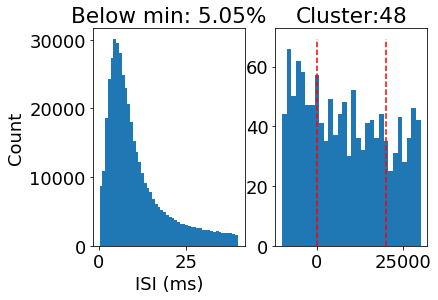

In [121]:
cluster_sum(spks,grid_trials,clust_use=11,x_use=45)

In [91]:
good_units = np.array([0,3,5,11,16])

<IPython.core.display.Javascript object>

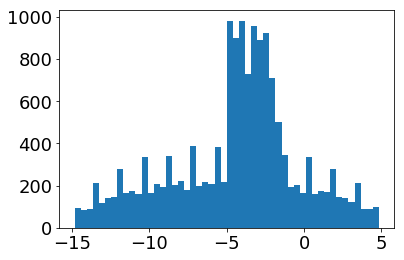

In [122]:
# N x val per X point
np.shape(stim_labels)
x_val = [x[0] for x in stim_labels ]
plt.hist(x_val,50)
plt.show()
#np.unique(x_val)

In [ ]:
trials_use = trials[]
def get_spk_vectors(clusts_use=[3,4]):
    pre_offset = -0*1000
    len_get = 30
   
    stim_labels = list(trials.stim_points)
    stim_labels = np.stack(trials.stim_points)
    st_time = np.array(trials_use.time_samples)
    ed_time = np.array(trials_use.stimulus_end)
    stim_len = ed_time[0] - st_time[0]
    
    clust = list(set(spks.cluster))
    spk_loc_all = list()
    for clust_use in clusts_use:
        # spike times to raster
        unit_use = clust[clust_use]
        spk_times = np.array(spks[spks.cluster==unit_use].time_samples)
        my_spikes = np.zeros(np.max(spk_times)+1,dtype=int)
        my_spikes[spk_times] = int(1)
        PSTH = spks_in_win(my_spikes,st_time+pre_offset,len_get*1000)
        spk_loc = np.where(PSTH>=1)
        spk_loc = [x+pre_offset for x in spk_loc]
        spk_loc_all.append(spk_loc)
    return spk_loc_all